# Analysis and Design of Multi-Layer Neural Networks (MLP)

## Table of Contents
- [MLP Design](#mlp-design)
- [Train Two Different Models](#train-two-different-models)
- [Back Propagation Algorithm](#back-propagation-algorithm)
- [Analysis of Different Hyperparameters](#analysis-of-different-hyperparameters)
- [References](#references)

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

## Utils

In [73]:
def plot_weight_histogram(model, layer_name, title='Weight Histogram'):
    plt.figure(figsize=(5, 3))
    weights = getattr(model, layer_name).weight.detach().cpu().numpy().flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.show()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(42)
torch.manual_seed(42)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cuda


In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

one issue was I tried to set the transformer this lambda bellow and the test loss was unbelievable!

## Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] 
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

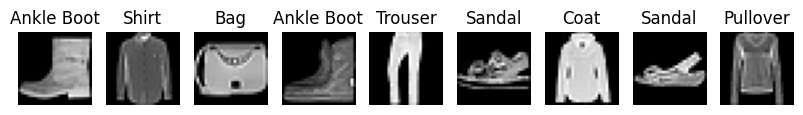

In [5]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 9,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## MLP Design

In [6]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [7]:
class Plotter:
    def __init__(self):
        pass

    @staticmethod
    def plot_curve(data, title: str):
        scale_x = range(1, len(data) + 1)

        plt.figure(figsize=(10, 4))
        plt.plot(scale_x, data)
        plt.xlabel("Epochs")
        plt.ylabel("SSE (Sum Squared Error)")
        plt.title(title)
        plt.show()

    @staticmethod        
    def plot_acc(train_acc, val_acc, name):
        plt.plot(train_acc, label=f'{name} Train Acc')
        plt.plot(val_acc, label=f'{name} Val Acc')

        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_loss():
        pass

    @staticmethod
    def plot_confusion_matrix(labels, preds, classes):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()
        return cm

In [8]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(all_labels, all_preds)
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(all_labels, all_preds)

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate) # optim.SGD(self.model.parameters(), lr=self.learning_rate)
        train_hist, test_hist = [], []
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            train_hist.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc})

        test_loss, test_acc = self.evaluate(test_loader)
        test_hist.append({"test_loss": test_loss, "test_acc": test_acc})
        return train_hist, test_hist

    def fit(self, loader, num_epochs):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train(loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

In [9]:
m = MLP(Model(100, do_rate=0.3), nn.CrossEntropyLoss())

In [10]:
num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = m.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/30], Train Loss: 1.4353, Train Acc: 0.5700
Epoch [2/30], Train Loss: 0.8724, Train Acc: 0.7091
Epoch [3/30], Train Loss: 0.7503, Train Acc: 0.7376
Epoch [4/30], Train Loss: 0.6888, Train Acc: 0.7596
Epoch [5/30], Train Loss: 0.6498, Train Acc: 0.7702
Epoch [6/30], Train Loss: 0.6222, Train Acc: 0.7815
Epoch [7/30], Train Loss: 0.5986, Train Acc: 0.7895
Epoch [8/30], Train Loss: 0.5814, Train Acc: 0.7963
Epoch [9/30], Train Loss: 0.5660, Train Acc: 0.8024
Epoch [10/30], Train Loss: 0.5540, Train Acc: 0.8058
Epoch [11/30], Train Loss: 0.5425, Train Acc: 0.8107
Epoch [12/30], Train Loss: 0.5317, Train Acc: 0.8131
Epoch [13/30], Train Loss: 0.5238, Train Acc: 0.8159
Epoch [14/30], Train Loss: 0.5144, Train Acc: 0.8195
Epoch [15/30], Train Loss: 0.5066, Train Acc: 0.8234
Epoch [16/30], Train Loss: 0.5009, Train Acc: 0.8249
Epoch [17/30], Train Loss: 0.4959, Train Acc: 0.8250
Epoch [18/30], Train Loss: 0.4886, Train Acc: 0.8290
Epoch [19/30], Train Loss: 0.4832, Train Acc: 0.8307
Ep

In [11]:
train_loss, _ = m.evaluate(train_loader)
print(f"Train Loss: {train_loss:.4f}")
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

Train Loss: 0.4041
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.84      0.82      6000
     Trouser       0.98      0.96      0.97      6000
    Pullover       0.77      0.76      0.77      6000
       Dress       0.86      0.88      0.87      6000
        Coat       0.75      0.81      0.78      6000
      Sandal       0.94      0.91      0.93      6000
       Shirt       0.68      0.59      0.63      6000
     Sneaker       0.91      0.91      0.91      6000
         Bag       0.95      0.95      0.95      6000
  Ankle boot       0.92      0.95      0.93      6000

    accuracy                           0.86     60000
   macro avg       0.86      0.86      0.86     60000
weighted avg       0.86      0.86      0.86     60000



In [12]:
# cm = Plotter().plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [13]:
test_loss, _ = m.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4389
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.81      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.74      0.74      0.74      1000
       Dress       0.83      0.86      0.85      1000
        Coat       0.73      0.77      0.75      1000
      Sandal       0.94      0.89      0.91      1000
       Shirt       0.64      0.57      0.60      1000
     Sneaker       0.89      0.91      0.90      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.91      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [14]:
# cm = Plotter().plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [15]:
# most_confused = {}
# for i in range(10):
#     row = cm[i]
#     row[i] = 0
#     most_confused_class = np.argmax(row)
#     most_confused[i] = most_confused_class

# for m in range(10):
#     print(f"Class `{class_names[m]}` is most often confused with class `{class_names[most_confused[m]]}`")

In [16]:
# conf_matrix_copy = cm.copy()
# np.fill_diagonal(conf_matrix_copy, 0)  # Zero the diagonal

# most_common_confusion = np.unravel_index(np.argmax(conf_matrix_copy), conf_matrix_copy.shape)

# # Print the most commonly confused classes
# print(f"The two most commonly confused classes are: `{class_names[most_common_confusion[0]]}` with `{class_names[most_common_confusion[1]]}`.")


#### Impact of Increasing Model Complexity

#### Criteria for Choosing the Best Configuration

- **Validation performance** : Monitor the validation accuracy and loss to ensure the model generalizes well.
- **Training stability** : Ensure that the model does not exhibit overfitting (training accuracy much higher than validation accuracy) or underfitting (both training and validation accuracies are low).
- **Computational efficiency** : Balance model complexity with computational resources (training time, memory usage).
- **Regularization** : Ensure proper regularization (e.g., dropout, L2 regularization) to prevent overfitting.

We can tune hyperparameters such as the number of layers, number of neurons per layer, regularization techniques, and learning rate to find the best configuration.

## Train Two Different Models

In [39]:
cirteria = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [40]:
model1 = Model(128)
model1.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (out): Linear(in_features=128, out_features=10, bias=True)
)>

In [41]:
model2 = Model(48, 0.2)
model2.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=48, out_features=10, bias=True)
)>

In [42]:
m1 = MLP(model1, cirteria)
m2 = MLP(model2, cirteria, lambda_reg=0.0001)

In [43]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = m1.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/40], Train Loss: 1.3584, Train Acc: 0.6128
Epoch [2/40], Train Loss: 0.7746, Train Acc: 0.7498
Epoch [3/40], Train Loss: 0.6595, Train Acc: 0.7732
Epoch [4/40], Train Loss: 0.6056, Train Acc: 0.7889
Epoch [5/40], Train Loss: 0.5714, Train Acc: 0.8006
Epoch [6/40], Train Loss: 0.5466, Train Acc: 0.8092
Epoch [7/40], Train Loss: 0.5278, Train Acc: 0.8154
Epoch [8/40], Train Loss: 0.5128, Train Acc: 0.8207
Epoch [9/40], Train Loss: 0.5004, Train Acc: 0.8252
Epoch [10/40], Train Loss: 0.4901, Train Acc: 0.8283
Epoch [11/40], Train Loss: 0.4814, Train Acc: 0.8315
Epoch [12/40], Train Loss: 0.4735, Train Acc: 0.8346
Epoch [13/40], Train Loss: 0.4667, Train Acc: 0.8368
Epoch [14/40], Train Loss: 0.4605, Train Acc: 0.8392
Epoch [15/40], Train Loss: 0.4548, Train Acc: 0.8415
Epoch [16/40], Train Loss: 0.4498, Train Acc: 0.8432
Epoch [17/40], Train Loss: 0.4450, Train Acc: 0.8440
Epoch [18/40], Train Loss: 0.4405, Train Acc: 0.8458
Epoch [19/40], Train Loss: 0.4362, Train Acc: 0.8476
Ep

In [44]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = m2.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/40], Train Loss: 1.5690, Train Acc: 0.5173
Epoch [2/40], Train Loss: 0.9550, Train Acc: 0.6837
Epoch [3/40], Train Loss: 0.8047, Train Acc: 0.7225
Epoch [4/40], Train Loss: 0.7330, Train Acc: 0.7433
Epoch [5/40], Train Loss: 0.6883, Train Acc: 0.7587
Epoch [6/40], Train Loss: 0.6555, Train Acc: 0.7699
Epoch [7/40], Train Loss: 0.6321, Train Acc: 0.7799
Epoch [8/40], Train Loss: 0.6104, Train Acc: 0.7859
Epoch [9/40], Train Loss: 0.5940, Train Acc: 0.7936
Epoch [10/40], Train Loss: 0.5802, Train Acc: 0.7979
Epoch [11/40], Train Loss: 0.5662, Train Acc: 0.8033
Epoch [12/40], Train Loss: 0.5544, Train Acc: 0.8071
Epoch [13/40], Train Loss: 0.5478, Train Acc: 0.8102
Epoch [14/40], Train Loss: 0.5396, Train Acc: 0.8137
Epoch [15/40], Train Loss: 0.5303, Train Acc: 0.8160
Epoch [16/40], Train Loss: 0.5241, Train Acc: 0.8179
Epoch [17/40], Train Loss: 0.5178, Train Acc: 0.8199
Epoch [18/40], Train Loss: 0.5133, Train Acc: 0.8223
Epoch [19/40], Train Loss: 0.5057, Train Acc: 0.8252
Ep

In [45]:
test_loss, _ = m1.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m1.all_labels, m1.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4226
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.82      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.73      0.77      0.75      1000
       Dress       0.83      0.88      0.86      1000
        Coat       0.75      0.77      0.76      1000
      Sandal       0.93      0.92      0.92      1000
       Shirt       0.66      0.57      0.61      1000
     Sneaker       0.91      0.92      0.91      1000
         Bag       0.94      0.95      0.94      1000
  Ankle boot       0.93      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [46]:
test_loss, _ = m2.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m2.all_labels, m2.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4346
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.83      0.81      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.74      0.75      0.74      1000
       Dress       0.84      0.86      0.85      1000
        Coat       0.74      0.76      0.75      1000
      Sandal       0.93      0.90      0.92      1000
       Shirt       0.65      0.58      0.61      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.94      0.95      0.94      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [54]:
weights = getattr(m1.model, 'out').weight.detach().cpu().numpy().flatten()

Model 1 Weight Histograms (128 Neurons, No Dropout)


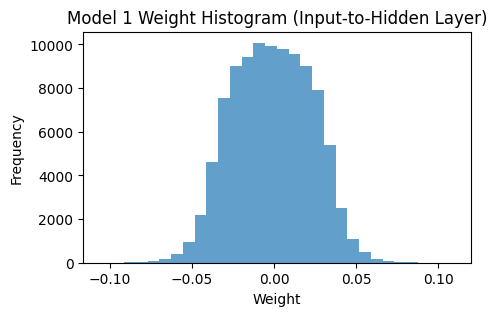

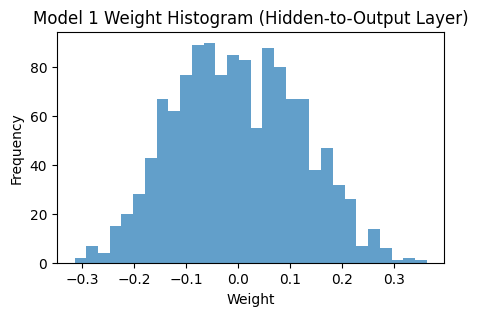

In [74]:
print("Model 1 Weight Histograms (128 Neurons, No Dropout)")
plot_weight_histogram(m1.model, 'fc1', 'Model 1 Weight Histogram (Input-to-Hidden Layer)')
plot_weight_histogram(m1.model, 'out', 'Model 1 Weight Histogram (Hidden-to-Output Layer)')

Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)


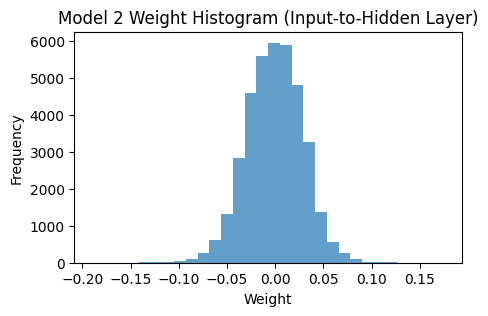

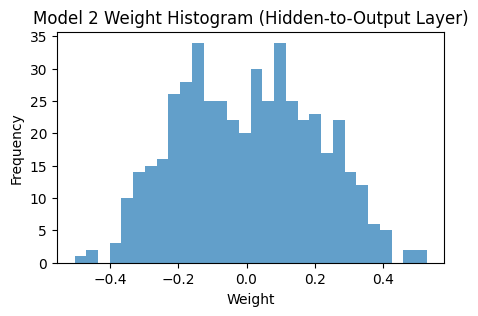

In [75]:
print("Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)")
plot_weight_histogram(m2.model, 'fc1', 'Model 2 Weight Histogram (Input-to-Hidden Layer)')
plot_weight_histogram(m2.model, 'out', 'Model 2 Weight Histogram (Hidden-to-Output Layer)')

In [ ]:
# Function to plot histograms for weights
def plot_histogram(model, layer_index):
    weights, biases = model.layers[layer_index].get_weights()
    plt.figure(figsize=(5, 3))
    plt.hist(weights.flatten(), bins=30)
    layer_name = model.layers[layer_index].name
    plt.title(f'Histogram of {layer_name} Layer Weights')
    plt.show()

In [ ]:
weights, biases = model1.layers[1].get_weights()
print(model1.layers[1].name)
weights, biases = model1.layers[2].get_weights()
print(model1.layers[2].name)
len(model1.layers)

In [ ]:
weights, biases = model2.layers[1].get_weights()
print(model2.layers[1].name)
weights, biases = model2.layers[3].get_weights()
print(model2.layers[3].name)
len(model2.layers)

In [ ]:
plot_histogram(model1, 1)
plot_histogram(model1, 2)

In [ ]:
plot_histogram(model2, 1)
plot_histogram(model2, 3)

In [ ]:
# Evaluate models on test data
test_loss1, test_acc1 = model1.evaluate(x_test, y_test)
test_loss2, test_acc2 = model2.evaluate(x_test, y_test)

print(f"Model 1 Test Accuracy: {test_acc1:.4f}")
print(f"Model 2 Test Accuracy: {test_acc2:.4f}")


## Back Propagation Algorithm

In [31]:
optimizers = { 
    'Adam': optim.Adam, 
    'NAdam': optim.NAdam, 
    'RMSprop': optim.RMSprop
}

In [32]:
model1 = Model(128)
model1.parameters
m1 = MLP(model1, nn.CrossEntropyLoss())

train_hist1, test_hist1 = m1.compile(optimizer=optimizers['Adam'], train_loader=train_loader, test_loader=test_loader, num_epochs=20)
for hist in train_hist1:
    print(hist)

{'epoch': 0, 'train_loss': 0.48596110699176787, 'train_acc': 0.82125}
{'epoch': 1, 'train_loss': 0.3760507553855578, 'train_acc': 0.8608166666666667}
{'epoch': 2, 'train_loss': 0.34186329795718196, 'train_acc': 0.8739666666666667}
{'epoch': 3, 'train_loss': 0.3190438083946705, 'train_acc': 0.8821}
{'epoch': 4, 'train_loss': 0.296560037056605, 'train_acc': 0.8913333333333333}
{'epoch': 5, 'train_loss': 0.2837493377963702, 'train_acc': 0.89515}
{'epoch': 6, 'train_loss': 0.271621926120917, 'train_acc': 0.8983166666666667}
{'epoch': 7, 'train_loss': 0.26036585841377574, 'train_acc': 0.9031166666666667}
{'epoch': 8, 'train_loss': 0.25057362221578755, 'train_acc': 0.9073333333333333}
{'epoch': 9, 'train_loss': 0.23950404344002404, 'train_acc': 0.9110333333333334}
{'epoch': 10, 'train_loss': 0.23671770769506692, 'train_acc': 0.9117833333333333}
{'epoch': 11, 'train_loss': 0.22534139470756054, 'train_acc': 0.9160666666666667}
{'epoch': 12, 'train_loss': 0.2199471361607313, 'train_acc': 0.9179

In [33]:
model2 = Model(128)
model2.parameters
m2 = MLP(model2, nn.CrossEntropyLoss())

train_hist2, test_hist2 = m2.compile(optimizer=optimizers['NAdam'], train_loader=train_loader, test_loader=test_loader, num_epochs=20)
for hist in train_hist2:
    print(hist)

{'epoch': 0, 'train_loss': 0.47599112195571264, 'train_acc': 0.828}
{'epoch': 1, 'train_loss': 0.36452457143863043, 'train_acc': 0.8664666666666667}
{'epoch': 2, 'train_loss': 0.3291283305803935, 'train_acc': 0.8791333333333333}
{'epoch': 3, 'train_loss': 0.30653352926572164, 'train_acc': 0.88715}
{'epoch': 4, 'train_loss': 0.28735976526935897, 'train_acc': 0.8940166666666667}
{'epoch': 5, 'train_loss': 0.2752368487298489, 'train_acc': 0.8982666666666667}
{'epoch': 6, 'train_loss': 0.26273945643107094, 'train_acc': 0.9021166666666667}
{'epoch': 7, 'train_loss': 0.2527600789631406, 'train_acc': 0.90635}
{'epoch': 8, 'train_loss': 0.24464323553740977, 'train_acc': 0.9093833333333333}
{'epoch': 9, 'train_loss': 0.23595208038389684, 'train_acc': 0.9119666666666667}
{'epoch': 10, 'train_loss': 0.2275390797217687, 'train_acc': 0.91415}
{'epoch': 11, 'train_loss': 0.2214146925896406, 'train_acc': 0.9177666666666666}
{'epoch': 12, 'train_loss': 0.21437513565023741, 'train_acc': 0.9192333333333

In [34]:
model3 = Model(128)
model3.parameters
m3 = MLP(model3, nn.CrossEntropyLoss())

train_hist3, test_hist3 = m3.compile(optimizer=optimizers['RMSprop'], train_loader=train_loader, test_loader=test_loader, num_epochs=20)
for hist in train_hist3:
    print(hist)

{'epoch': 0, 'train_loss': 0.4850892056107521, 'train_acc': 0.8219333333333333}
{'epoch': 1, 'train_loss': 0.37277591596841814, 'train_acc': 0.8632166666666666}
{'epoch': 2, 'train_loss': 0.33881808224320414, 'train_acc': 0.8755}
{'epoch': 3, 'train_loss': 0.31546411098738514, 'train_acc': 0.8837833333333334}
{'epoch': 4, 'train_loss': 0.29775588106314343, 'train_acc': 0.8907833333333334}
{'epoch': 5, 'train_loss': 0.2824590995967388, 'train_acc': 0.8956833333333334}
{'epoch': 6, 'train_loss': 0.2709326993584633, 'train_acc': 0.8991}
{'epoch': 7, 'train_loss': 0.2618185885796944, 'train_acc': 0.9029666666666667}
{'epoch': 8, 'train_loss': 0.25181682859460514, 'train_acc': 0.9069}
{'epoch': 9, 'train_loss': 0.2432876366953055, 'train_acc': 0.9098}
{'epoch': 10, 'train_loss': 0.23626795104444026, 'train_acc': 0.91155}
{'epoch': 11, 'train_loss': 0.22840425451000532, 'train_acc': 0.91485}
{'epoch': 12, 'train_loss': 0.22058257934053738, 'train_acc': 0.9178166666666666}
{'epoch': 13, 'trai

In [35]:
test_loss1, _ = m1.test(test_loader)
print(f"Test Loss: {test_loss1:.4f}")
print(classification_report(m1.all_labels, m1.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.3969
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.78      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.83      0.75      0.79      1000
       Dress       0.86      0.91      0.89      1000
        Coat       0.82      0.80      0.81      1000
      Sandal       0.94      0.97      0.95      1000
       Shirt       0.65      0.76      0.70      1000
     Sneaker       0.95      0.91      0.93      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [36]:
test_loss2, _ = m2.test(test_loader)
print(f"Test Loss: {test_loss2:.4f}")
print(classification_report(m2.all_labels, m2.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.3984
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.82      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.77      0.84      0.80      1000
       Dress       0.84      0.92      0.88      1000
        Coat       0.82      0.79      0.81      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.74      0.64      0.68      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.97      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [37]:
test_loss3, _ = m3.test(test_loader)
print(f"Test Loss: {test_loss3:.4f}")
print(classification_report(m3.all_labels, m3.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4318
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.83      1000
     Trouser       0.97      0.98      0.97      1000
    Pullover       0.83      0.75      0.79      1000
       Dress       0.88      0.87      0.88      1000
        Coat       0.76      0.85      0.81      1000
      Sandal       0.94      0.96      0.95      1000
       Shirt       0.74      0.66      0.70      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.93      0.97      0.95      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [38]:
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# # Normalize the data (0 to 1 range)
# # If you ignore here, you'll get a huge bias.
# x_train = x_train / 255.0
# x_test = x_test / 255.0

# x_train.shape

## Analysis of Different Hyperparameters

## References

- [Ref1]()
- [Ref2]()
- [Ref3]()